# Galactic Bulge Extended Survey Region

Multiple surveys monitor the Galactic Bulge at different cadences.  KMTNet in particular surveys the central Bulge region at high (~15min) cadence, making follow-up unnecessary for these events. 

OGLE have now expanded their survey region in the Bulge to include a wider range of fields at a 1-2 day cadence. 

By comparing the OGLE and KMTNet survey fields, we can identify those regions for which follow-up would be needed. 

In [63]:
import csv
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, Column
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import read_events_table
import healpixel_functions

The first set of KMTNet field locations were identified by aggregating the locations of their detected events. Assuming that they are providing the same cadence across all fields, this would imply that effectively none of this region would need follow-up.  However, area includes around 55 KMTNet pointings, over an area of ~223 sq.deg., and survey logistics imply that they cannot feasibly survey this area at 15min cadence.  

Further information from Zang et al 2018 [https://ui.adsabs.harvard.edu/abs/2018AJ....156..236Z/abstract] describes the strategy in somewhat more detail: "Currently, a total of (3, 7, 11, 3) fields are observed at cadences Γ = (4,1,0.4,0.2) hr−1, ..."

This would imply a total of 24 survey fields however, whereas there are events detected from 223 1-deg HEALpixels.
The survey strategy since then may have changed.

More recently, Jung et al. [https://ui.adsabs.harvard.edu/abs/2022AJ....164..262J/abstract] described a set of 6 "prime" fields (or 24 sq.deg) receiving a cadence of 2 visits/hour, and a set of "sub-prime" fields. The sub-prime fields are further sub-divided into 7, 10 and 3 fields, receiving 1, 0.4 and 0.2 visits per hour (or a cadence of every 1hr, 2.5hr, and 5hr).

This would also imply a total of 26 field pointings. Even assuming the field of view is 2x2deg, there are events being detected from an area spanning around 55 KMTNet pointings. That suggests a rotating set of sub-prime fields.

The Jung paper references Kim et al. 2018 [https://ui.adsabs.harvard.edu/abs/2018AJ....155...76K/abstract] as providing a map of the survey fields and cadences, Fig. 12. No table of field centres is given in that paper.  Instead, we use the field locations plotted in that figure to identify those fields covered at high cadence.

In [64]:
kmtnet_survey_fields_file = './kmtnet/kmtnet_survey_fields_kim2018.csv'
kmtnet_fov = 2.0 # deg on a side, square
ogle_survey_fields_file = './ogle/ogle_survey_fields.csv'
ogle_fov = np.sqrt(1.4) # deg on a side

In [65]:
def read_survey_fields(file_path):
    data = []
    ra = []
    dec = []
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            data.append(row)
    data = np.array(data)
    
    field_centres = SkyCoord(data[:,0], data[:,1], frame='icrs', unit=(u.hourangle, u.deg))
    
    data_table = Table(
                        [Column(data=data[:,0], name='RA'),
                        Column(data=data[:,1], name='Dec')]
                        )

    return data_table, field_centres


In [66]:
def read_kmtnet_survey_fields(file_path):
    data = []
    ra = []
    dec = []
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            if '#' not in row[0]:
                data.append([row[0],float(row[1]),float(row[2]),float(row[3])])
    data = np.array(data)
    
    field_centres = SkyCoord(data[:,1], data[:,2], frame='icrs', unit=(u.deg, u.deg))
    data_table = Table(
                        [Column(data=data[:,0], name='Field_ID', dtype=float),
                        Column(data=data[:,1], name='RA', dtype=float),
                        Column(data=data[:,2], name='Dec', dtype=float),
                        Column(data=data[:,3], name='Cadence', dtype=float)]
                        )

    return data_table, field_centres


In [67]:
(kmtnet_data, kmtnet_fields) = read_kmtnet_survey_fields(kmtnet_survey_fields_file)
(ogle_data, ogle_fields) = read_survey_fields(ogle_survey_fields_file)

Text(0, 0.5, 'Dec [deg]')

<Figure size 1000x1000 with 0 Axes>

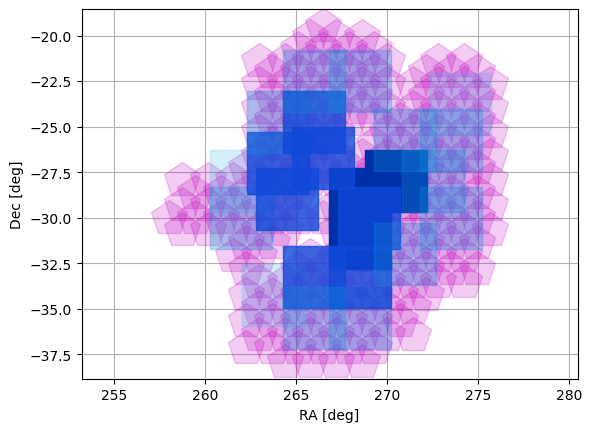

In [68]:
ra_min = 260.0
ra_max = 276.0
dec_min = -37.5
dec_max = -20.0

plot_width = 10.0
plot_height = 10.0

ra_scale = plot_width / (ra_max-ra_min) # inches / deg
dec_scale = plot_height / (dec_max-dec_min)

# A standard plot markersize=1 is equivalent to 1/72 inches.  
markersize = 1.0/72.0 # inch

kmarker = (ra_scale * kmtnet_fov/2.0) / markersize
omarker = (ra_scale * ogle_fov/2.0) / markersize

plt.figure(figsize=(plot_width, plot_height))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('equal')
plt.grid()

plt.plot(ogle_fields.ra.deg, ogle_fields.dec.deg, color='m', marker='p', 
         markersize=omarker,  linestyle="None", alpha=0.2)

for row in kmtnet_data:
    if row['Cadence'] == 0.25:
        opacity = 1.0
        color = '#0030A7'
    elif row['Cadence'] == 1.0:
        opacity = 0.8
        color = '#1049D9'
    elif row['Cadence'] == 2.5:
        opacity = 0.3
        color = '#108AD9'
    elif row['Cadence'] == 5.0:
        opacity = 0.2
        color = '#28B4E5'
    plt.plot(row['RA'], row['Dec'], color=color, marker='s', 
         markersize=kmarker,  linestyle="None", alpha=opacity)

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
#plt.legend()

In the figure above, OGLE fields are plotted in purple pentagons - these fields are expected to be surveyed at 1-2 visits per night by OGLE.  

KMTNet fields are plotted as blue squares, with opacity and color scaled to reflect high (fully opaque/dark) and low (lighter, less opaque) cadence fields.  

This indicates a substantial region in the Bulge where events are not covered at high enough cadence to fully characterize planetary anomalies.  

Next, let's compare this with the distribution of detected events. 

In [69]:
kmtnet_event_file = './kmtnet/kmtnet_event_list.csv'
ogle_event_file = './ogle/ogle4_event_list.csv'
ogle_events = read_events_table.read_event_list(ogle_event_file)
kmtnet_events = read_events_table.read_event_list(kmtnet_event_file)

ogle_positions = SkyCoord(ogle_events['RA'].data, ogle_events['Dec'].data, frame='icrs', unit=(u.hourangle, u.deg))
kmtnet_positions = SkyCoord(kmtnet_events['RA'].data, kmtnet_events['Dec'].data, frame='icrs', unit=(u.hourangle, u.deg))

<Figure size 1000x1000 with 0 Axes>

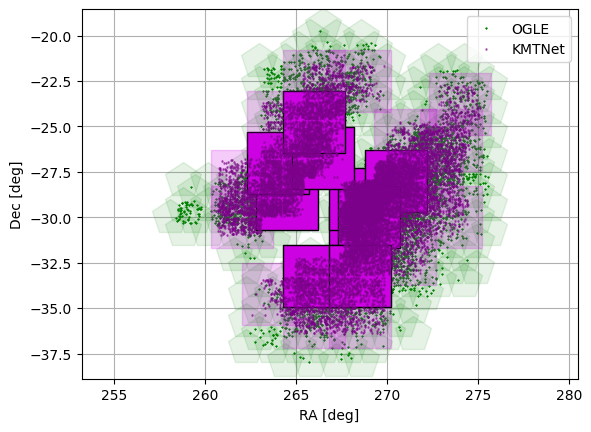

In [101]:
ra_min = 260.0
ra_max = 276.0
dec_min = -37.5
dec_max = -20.0

plot_width = 10.0
plot_height = 10.0

ra_scale = plot_width / (ra_max-ra_min) # inches / deg
dec_scale = plot_height / (dec_max-dec_min)

# A standard plot markersize=1 is equivalent to 1/72 inches.  
markersize = 1.0/72.0 # inch

kmarker = (ra_scale * kmtnet_fov/2.0) / markersize
omarker = (ra_scale * ogle_fov/2.0) / markersize

plt.figure(figsize=(plot_width, plot_height))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('equal')
plt.grid()

plt.plot(ogle_fields.ra.deg, ogle_fields.dec.deg, color='g', marker='p', 
         markersize=omarker,  linestyle="None", alpha=0.1)
plt.plot(ogle_positions.ra.deg, ogle_positions.dec.deg, color='g', marker='*', markersize=1, linestyle='none', label='OGLE')

for row in kmtnet_data:
    if row['Cadence'] == 0.25:
        opacity = 0.2
        color = '#cd02e3'
        plt.plot(row['RA'], row['Dec'], color=color, marker='s', 
         markersize=kmarker,  linestyle='-', linewidth=0, alpha=opacity)
        plt.plot(row['RA'], row['Dec'], color=color, marker='s', markeredgecolor='k',
         markersize=kmarker,  linestyle='-', linewidth=10, alpha=1.0)
    elif row['Cadence'] == 1.0:
        opacity = 0.2
        color = '#cd02e3'
        plt.plot(row['RA'], row['Dec'], color=color, marker='s', 
         markersize=kmarker,  linestyle='-', linewidth=0, alpha=opacity)
        plt.plot(row['RA'], row['Dec'], color=color, marker='s', markeredgecolor='k',
         markersize=kmarker,  linestyle='-', linewidth=10, alpha=1.0)
    elif row['Cadence'] == 2.5:
        opacity = 0.2
        color = '#cd02e3'
        plt.plot(row['RA'], row['Dec'], color=color, marker='s', 
         markersize=kmarker,  linestyle="None", alpha=opacity)
    elif row['Cadence'] == 5.0:
        opacity = 0.2
        color = '#cd02e3'
        plt.plot(row['RA'], row['Dec'], color=color, marker='s', 
         markersize=kmarker,  linestyle="None", alpha=opacity)

plt.plot(kmtnet_positions.ra.deg, kmtnet_positions.dec.deg, color='#7c018a', marker='d', 
         markersize=1, linestyle='none', alpha=0.5, label='KMTNet')

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.legend()
plt.savefig('bulge_extended_zone.png')

## Bulge regions with low survey cadence

So it appears that there is a significant number of events in the low-cadence Bulge region that would benefit from follow-up.  

So the next step is to identify those OGLE fields which should be excluded from follow-up, and output a HEALpixel table of event rate in a format which can be used by the kp_simulator.  

The code skymap_events.py was used to produce maps of the OGLE and KMTNet detected event rate per HEALpixel, so we read those data in now.

In [71]:
def read_event_rate_table(map_file_path):
    with fits.open(map_file_path) as hdul:
        data_table = hdul[1].data

    coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

    event_rate_table = Table([
                                Column(name="HP", data=data_table['hp_index'], dtype='int'),
                                Column(name="RA", data=data_table['RA'], dtype='str'),
                                Column(name="Dec", data=data_table['Dec'], dtype='str'),
                                Column(name="field_centre", data=coords),
                                Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                                ])
    return event_rate_table

In [72]:
ogle_map_file = './ogle/ogle_event_rate.fits' # Generated with OGLE4 data only
kmtnet_map_file = './kmtnet/kmtnet_event_rate.fits'

ogle_map = read_event_rate_table(ogle_map_file)
kmtnet_map = read_event_rate_table(kmtnet_map_file)
ogle_map['Gamma'].max()

105.625

Initialize a survey zone holding array for our output map 

In [73]:
survey_zone = np.zeros(len(ogle_map))
survey_zone = ogle_map['Gamma']


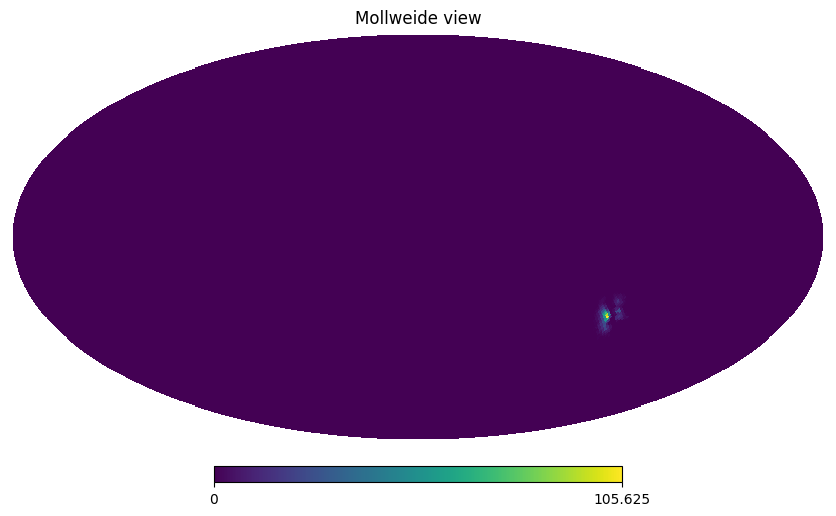

In [74]:
hp.mollview(survey_zone)

Working through the KMTNet high-cadence field locations, we calculate which HEALpixels these overlap, so that we can exclude these regions from the final survey map. 

In [75]:
def calc_hp_healpixels_for_region(s,radius,NSIDE):
    """Method calculates the HEALpixels included within a region centred on SkyCoord s with radius given in degrees.
    If the radius of the region is smaller than half that of the HEALpixel map
    resolution, then a minimum radius of 1 HEALpixel is imposed. 
    SkyCoord s should be ICRS"""

    phi = np.deg2rad(s.ra.deg)
    theta = (np.pi/2.0) - np.deg2rad(s.dec.deg)
    radius = max(np.deg2rad(radius),
                 np.deg2rad(hp.max_pixrad(NSIDE,degrees=True)/2.0))
    xyz = hp.ang2vec(theta, phi)
    pixels = hp.query_disc(NSIDE, xyz, radius)
    return pixels

In [76]:
#Estimate search radius based on the size of the KMTNet Field of view (set earlier as degrees on a box side):
radius = np.sqrt(kmtnet_fov*kmtnet_fov / np.pi)
NSIDE = 64
for row in kmtnet_data:
    if row['Cadence'] <= 1.0:
        s = SkyCoord(row['RA'], row['Dec'], frame='icrs', unit=(u.deg, u.deg))
        pixels = calc_hp_healpixels_for_region(s,radius,NSIDE)
        print(len(pixels))
        survey_zone[pixels] = 0.0

4
4
4
6
5
6
5
4
4
5


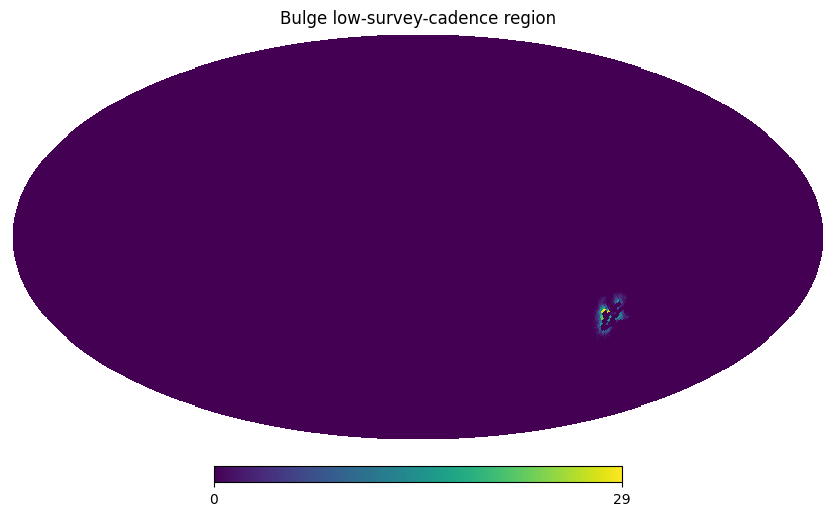

In [77]:
hp.mollview(survey_zone, title='Bulge low-survey-cadence region')

Output a FITS table of the event rate data:

In [78]:
hp_fields_ra = []
hp_fields_dec = []
for ihp in range(0,len(survey_zone),1):
    field_centre = healpixel_functions.HPindex_to_skycoord(ihp, NSIDE)
    (ra,dec) = field_centre.to_string('hmsdms', sep=':')[0].split()
    hp_fields_ra.append(ra)
    hp_fields_dec.append(dec)

hdr = fits.Header()
hdr['NSIDE'] = NSIDE
hdr['NPIX'] = hp.nside2npix(NSIDE)
hdr['ORDER'] = 'RING'
hdr['MAPTITLE'] = 'Event rate'
phdu = fits.PrimaryHDU(header=hdr)

c1 = fits.Column(name='hp_index', array=range(1,len(survey_zone),1), format='I8')
c2 = fits.Column(name='RA', array=hp_fields_ra, format='12A')
c3 = fits.Column(name='Dec', array=hp_fields_dec, format='12A')
c4 = fits.Column(name='gamma', array=survey_zone, format='E')
hdu = fits.BinTableHDU.from_columns([c1,c2,c3,c4])

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('bulge_extended_zone_map.fits', overwrite=True)